In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from matplotlib import pyplot as plt
from tqdm import trange
from torch.distributions.normal import Normal
from torch.distributions.laplace import Laplace
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

# CNN

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)
        self.conv_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.relu = nn.ReLU()
        self.pooling = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(in_features=1600, out_features=10)

    def forward(self, x):
        x = self.relu(self.conv_0(x))
        x = self.pooling(x)
        x = self.relu(self.conv_1(x))
        x = self.pooling(x)
        x = x.view(-1, 1600)
        x = self.fc(x)
        return x

In [4]:
cnn = CNN()

In [5]:
cnn.load_state_dict(torch.load('./models/mnist_cnn'))

<All keys matched successfully>

In [5]:
dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])

In [49]:
train_dataloader = DataLoader(train_set, batch_size = 128, shuffle=True)
test_dataloader = DataLoader(val_set, batch_size = 1000, shuffle=True)

In [9]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr = 1e-3)

In [10]:
n_epochs = 600
device = 'cuda'

In [12]:
cnn_writer = SummaryWriter()
cnn = cnn.to(device)
for i in trange(n_epochs):
    total_loss = 0
    for (x, y) in iter(train_dataloader):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        y_pred = cnn(x)
        loss = cross_entropy(y_pred, y)
        total_loss += loss
        loss.backward()
        optimizer.step()
    cnn_writer.add_scalar('Loss/train', total_loss / (len(train_dataloader)), i)
    if i % 15 == 0:
        cnn.eval()
        with torch.no_grad():
            total_loss = 0
            accuracy = 0
            for (x, y) in iter(test_dataloader):
                x = x.to(device)
                y = y.to(device)

                y_pred = cnn(x)
                loss_test = cross_entropy(y_pred, y)   
                total_loss += loss_test
                accuracy += (torch.argmax(y_pred, dim = -1) == y).sum() / len(y)
            cnn_writer.add_scalar('Loss/test', total_loss / len(test_dataloader), i)
            cnn_writer.add_scalar('Accuracy/test', accuracy / len(test_dataloader), i)
        cnn.train()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [1:21:15<00:00,  8.13s/it]


In [60]:
cnn_writer.flush()

In [61]:
cnn_writer.close()

In [13]:
cnn.eval()
with torch.no_grad():
    total_loss = 0
    accuracy = 0
    for (x, y) in iter(test_dataloader):
        x = x.to(device)
        y = y.to(device)

        y_pred = cnn(x)
        loss_test = cross_entropy(y_pred, y)   
        total_loss += loss_test
        accuracy += (torch.argmax(y_pred, dim = -1) == y).sum() / len(y)

In [14]:
accuracy / len(test_dataloader)

tensor(0.9877, device='cuda:0')

In [15]:
cnn

CNN(
  (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1600, out_features=10, bias=True)
)

In [44]:
torch.save(cnn.state_dict(), './models/mnist_cnn')

In [12]:
cnn_parameters = []
for param in cnn.parameters():
    cnn_parameters += param.view(-1, np.prod(param.shape)).detach().cpu().squeeze().tolist()

Text(0.5, 1.0, "Histogram with 'auto' bins")

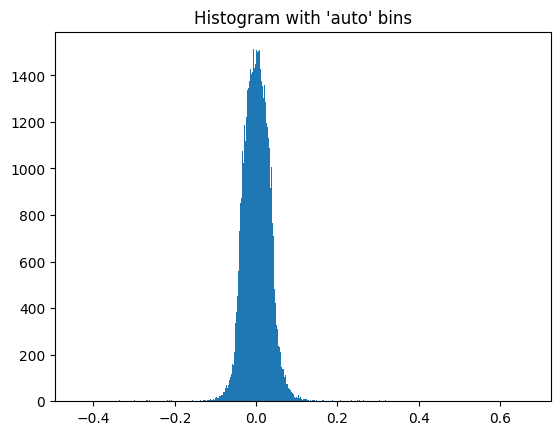

In [19]:
import matplotlib.pyplot as plt

_ = plt.hist(cnn_parameters, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")

# FCNN

In [6]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_0 = nn.Linear(in_features = 28*28, out_features=100)
        self.fc_1 = nn.Linear(in_features = 100, out_features=100)
        self.fc_2 = nn.Linear(in_features = 100, out_features=10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc_0(x))
        x = self.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

In [7]:
fcnn = FCNN()

In [8]:
fcnn.load_state_dict(torch.load('./models/mnist_fcnn'))

<All keys matched successfully>

In [52]:
n_epochs = 600

In [53]:
fcnn_writer = SummaryWriter()
fcnn = fcnn.to(device)
for i in trange(n_epochs):
    total_loss = 0
    for (x, y) in iter(train_dataloader):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        y_pred = fcnn(x)
        loss = cross_entropy(y_pred, y)
        total_loss += loss
        loss.backward()
        optimizer.step()
    fcnn_writer.add_scalar('Loss/train', total_loss / (len(train_dataloader)), i)
    if i % 15 == 0:
        fcnn.eval()
        with torch.no_grad():
            total_loss = 0
            accuracy = 0
            for (x, y) in iter(test_dataloader):
                x = x.to(device)
                y = y.to(device)

                y_pred = fcnn(x)
                loss_test = cross_entropy(y_pred, y)   
                total_loss += loss_test
                accuracy += (torch.argmax(y_pred, dim = -1) == y).sum() / len(y)
            fcnn_writer.add_scalar('Loss/test', total_loss / len(test_dataloader), i)
            fcnn_writer.add_scalar('Accuracy/test', accuracy / len(test_dataloader), i)
        fcnn.train()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [1:21:22<00:00,  8.14s/it]


In [62]:
fcnn_writer.flush()

In [63]:
fcnn_writer.close()

In [64]:
fcnn.eval()
with torch.no_grad():
    total_loss = 0
    accuracy = 0
    for (x, y) in iter(test_dataloader):
        x = x.to(device)
        y = y.to(device)

        y_pred = fcnn(x)
        loss_test = cross_entropy(y_pred, y)   
        total_loss += loss_test
        accuracy += (torch.argmax(y_pred, dim = -1) == y).sum() / len(y)

In [65]:
accuracy / len(test_dataloader)

tensor(0.1100, device='cuda:0')

In [66]:
fcnn

FCNN(
  (fc_0): Linear(in_features=784, out_features=100, bias=True)
  (fc_1): Linear(in_features=100, out_features=100, bias=True)
  (fc_2): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)

In [57]:
torch.save(fcnn.state_dict(), './models/mnist_fcnn')

In [11]:
fcnn_parameters = []
for param in fcnn.parameters():
    fcnn_parameters += param.view(-1, np.prod(param.shape)).detach().cpu().squeeze().tolist()

In [34]:
fcnn_norm, fcnn_lapl = get_norm_and_laplacian(fcnn_parameters)

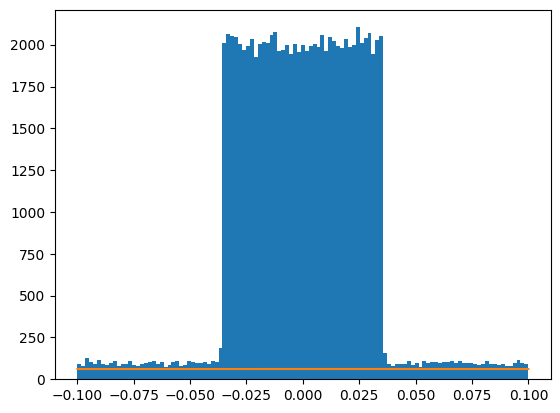

In [41]:
_, bins, _ = plt.hist(fcnn_parameters, bins="auto")  # arguments are passed to np.histogram
num_bins = len(bins)
bin_width = (max(fcnn_parameters) - min(fcnn_parameters)) / num_bins
plt.plot(y, stats.norm.pdf(y) * len(fcnn_parameters) * bin_width)
plt.show()
#plt.title("Histogram with 'auto' bins")

# ResNet20

In [45]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

In [46]:
class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm2(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        print(x.shape)
        print(identity.shape)
        x += identity
        x = self.relu(x)
        return x

In [47]:
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

In [48]:
def ResNet20(num_classes, channels=3):
    return ResNet(Bottleneck, [2,2,3,2], num_classes, channels)

In [49]:
resnet20 = ResNet20(10)

In [50]:
resnet20.load_state_dict(torch.load('./models/cifar10_resnet20'))

<All keys matched successfully>

In [51]:
resnet20_parameters = []
for param in resnet20.parameters():
    resnet20_parameters += param.view(-1, np.prod(param.shape)).detach().cpu().squeeze().tolist()

# Plotting

In [16]:
import pylab 
import scipy.stats as stats

## Normal

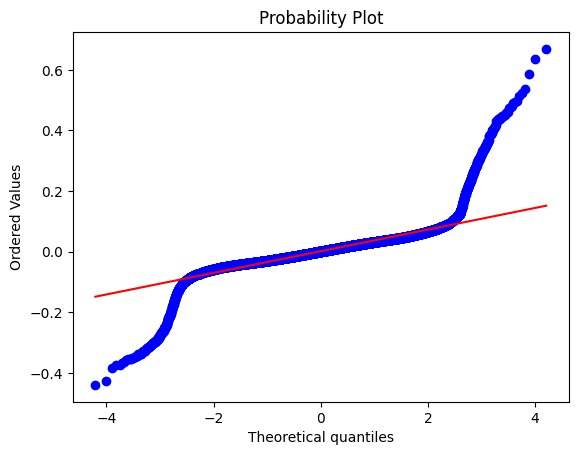

In [20]:
stats.probplot(cnn_parameters, dist="norm", plot=pylab)
pylab.show()

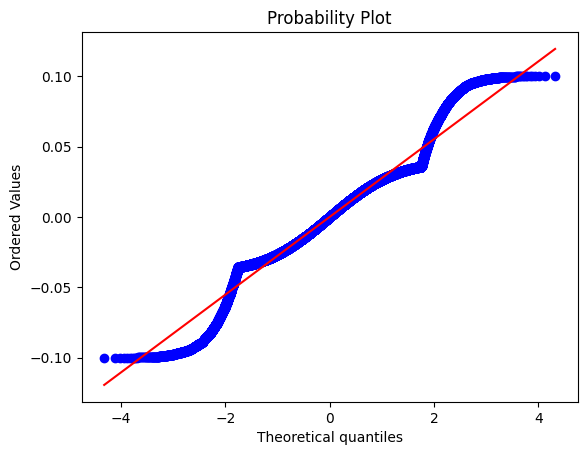

In [21]:
stats.probplot(fcnn_parameters, dist="norm", plot=pylab)
pylab.show()

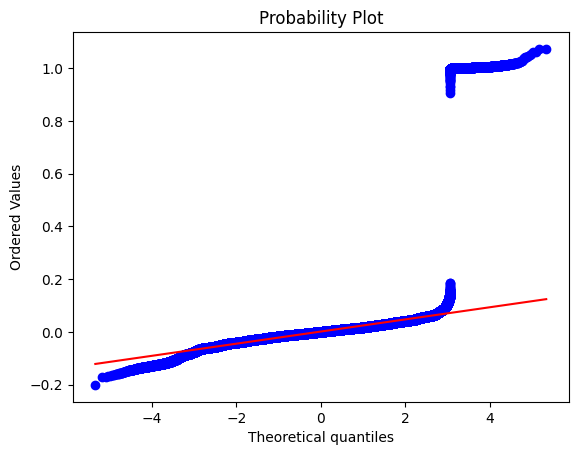

In [23]:
stats.probplot(resnet20_parameters, dist="norm", plot=pylab)
pylab.show()

## Laplacian

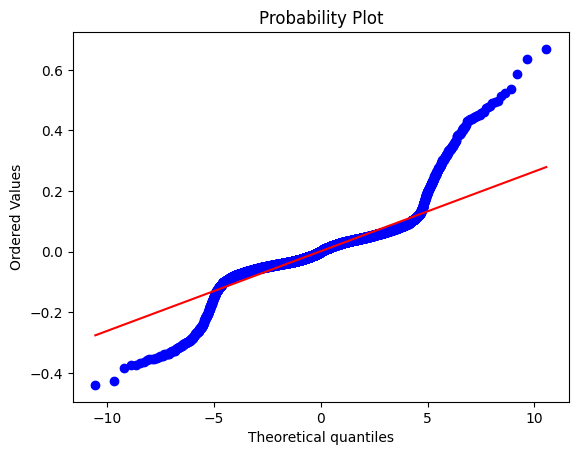

In [24]:
stats.probplot(cnn_parameters, dist="laplace", plot=pylab)
pylab.show()

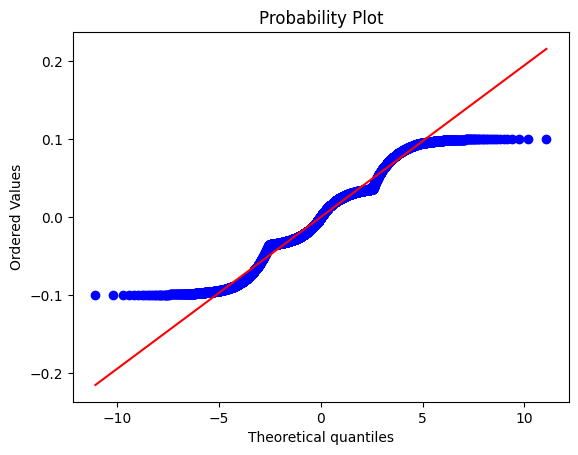

In [25]:
stats.probplot(fcnn_parameters, dist="laplace", plot=pylab)
pylab.show()

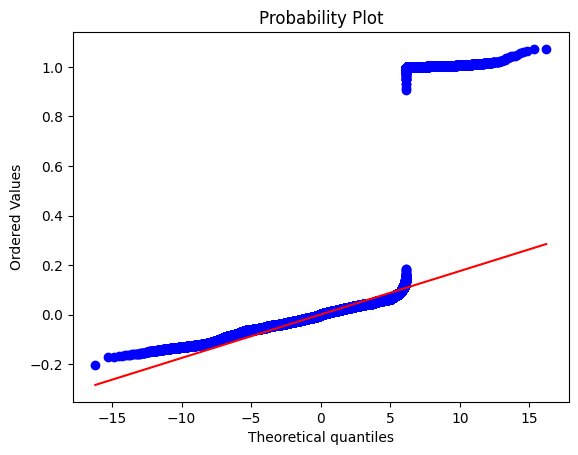

In [26]:
stats.probplot(resnet20_parameters, dist="laplace", plot=pylab)
pylab.show()

# Hists

In [52]:
from scipy.stats import norm, laplace

In [53]:
def plot_norm_and_laplacian(parameters):
    mu, std = norm.fit(parameters)
    # Plot the histogram.
    plt.hist(parameters, bins="auto", density=True, alpha=0.6)

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    l = laplace.pdf(x, mu, std)

    plt.plot(x, p, linewidth=2)
    plt.plot(x, l, linewidth=2)
    title = "Mean: {:.3f}. Std {:.3f}".format(mu, std)
    plt.title(title)

    plt.show()

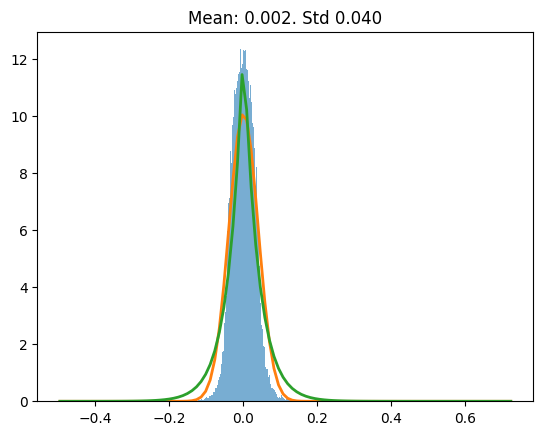

In [54]:
plot_norm_and_laplacian(cnn_parameters)

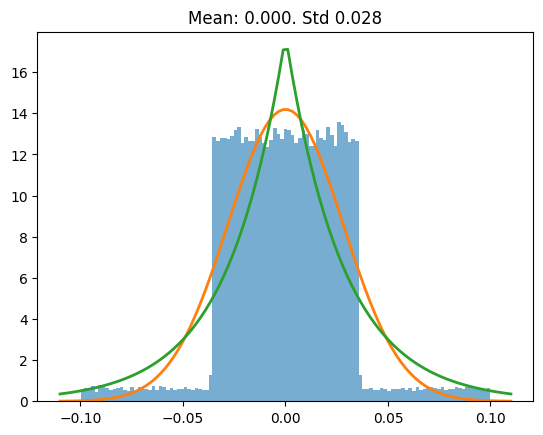

In [55]:
plot_norm_and_laplacian(fcnn_parameters)

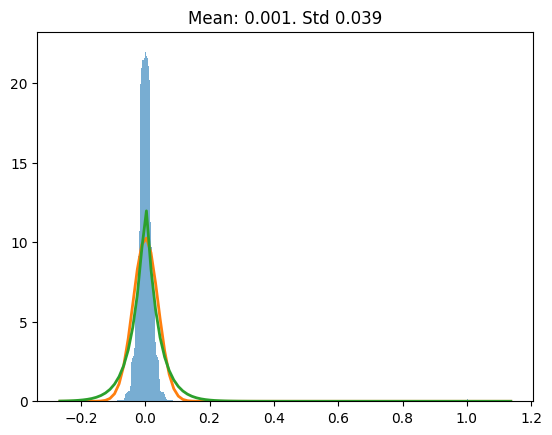

In [57]:
plot_norm_and_laplacian(resnet20_parameters)